In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

# ---------------------------------------------------------
# 1. CARGA Y LIMPIEZA DE DATOS
# ---------------------------------------------------------
# Recreamos el dataframe basado en tu imagen
# (En tu notebook real, puedes cargar esto con pd.read_csv o pd.read_excel)

data = {
    'Fecha': pd.to_datetime([
        '2022-01-01', '2022-02-01', '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01',
        '2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01', '2022-11-01', '2022-12-01',
        '2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01',
        '2023-07-01', '2023-08-01', '2023-09-01', '2023-10-01', '2023-11-01', '2023-12-01',
        '2024-01-01', '2024-02-01', '2024-03-01', '2024-04-01', '2024-05-01', '2024-06-01',
        '2024-07-01', '2024-08-01', '2024-09-01', '2024-10-01', '2024-11-01', '2024-12-01',
        '2025-01-01', '2025-02-01', '2025-03-01', '2025-04-01', '2025-05-01', '2025-06-01',
        '2025-07-01', '2025-08-01', '2025-09-01', '2025-10-01', '2025-11-01', '2025-12-01'
    ]),
    'GAM': [
        47555, 33752, 50401, 88518, 52899, 74406, 117898, 106035, 48593, 45272, 45395, 60313,
        0, 0, 0, 0, 65396, 95181, 165041, 140610, 57745, 49379, 53081, 72613,
        49328, 43293, 70971, 76619, 58704, 69427, 123249, 97003, 36239, 23176, 24855, 31070,
        23727, 20156, 29739, 43406, 38977, 50204, 93354, 78757, 34471, 19695, 21122, 18624
    ],
    'Turistas': [
        187397, 195151 ,259592 ,286375 ,269962 ,278759 ,280636 ,278508 ,203882 ,216805 ,215150 ,199069, 
        205542, 224725, 205546, 259069, 238674, 215920, 203918, 220828, 182708, 194643, 207397, 203761,
        186327, 191706, 240656, 232581, 233522, 245496, 277021, 254396, 169104, 151484, 160698, 159184,
        111926, 119146, 145608, 170683, 165415, 180548, 208976, 286940, 200755, 174446, 185057, 183313
    ]
}

df = pd.DataFrame(data)

# Filtrar datos válidos para correlación (donde ambos > 0)
df_valid = df[(df['GAM'] > 0) & (df['Turistas'] > 0)].copy()

# ---------------------------------------------------------
# 2. ANÁLISIS DE CORRELACIÓN
# ---------------------------------------------------------
corr = df_valid['GAM'].corr(df_valid['Turistas'])
print(f"--- RESULTADOS DEL ANÁLISIS ---")
print(f"Correlación de Pearson (GAM vs Turistas): {corr:.4f}")
# Interpretación rápida
if corr > 0.7:
    print("Interpretación: Correlación Fuerte. Los turistas predicen muy bien al GAM.")
elif corr > 0.4:
    print("Interpretación: Correlación Moderada.")
else:
    print("Interpretación: Correlación Débil.")

# Calcular el 'Capture Rate' promedio (Qué % de turistas van al GAM)
df_valid['Capture_Rate'] = df_valid['GAM'] / df_valid['Turistas']
avg_capture_rate = df_valid['Capture_Rate'].mean()
print(f"Tasa de Captura Promedio (GAM/Turistas): {avg_capture_rate:.2%}")



--- RESULTADOS DEL ANÁLISIS ---
Correlación de Pearson (GAM vs Turistas): 0.6321
Interpretación: Correlación Moderada.
Tasa de Captura Promedio (GAM/Turistas): 27.88%


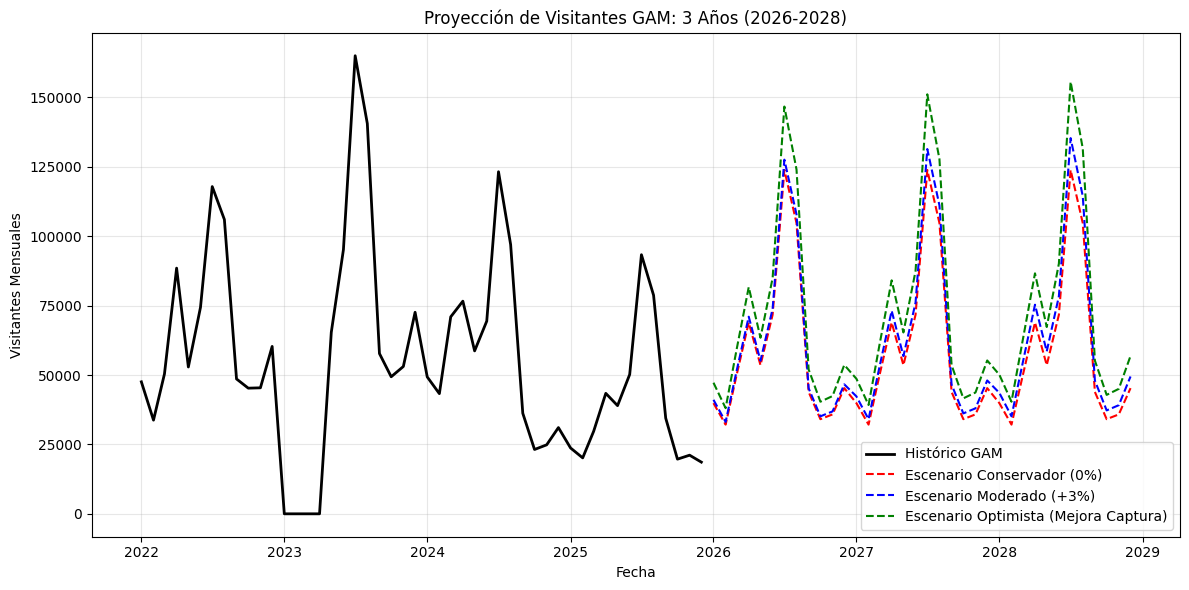


--- RESUMEN PROYECCIÓN 2026 (ESCENARIO MODERADO) ---
       Fecha      Pred_GAM
0 2026-01-01  41073.906630
1 2026-02-01  33101.938466
2 2026-03-01  51461.065457
3 2026-04-01  71019.614545
4 2026-05-01  55163.199931
5 2026-06-01  73870.200197


In [4]:
# ---------------------------------------------------------
# 3. PROYECCIONES A 3 AÑOS (Modelado Estacional)
# ---------------------------------------------------------
# Función simple para proyectar usando índices estacionales y crecimiento
def project_future(df_hist, metric_col, years=3, growth_scenario=0.0):
    # 1. Calcular índice estacional (promedio de cada mes)
    df_hist['Month'] = df_hist['Fecha'].dt.month
    monthly_avg = df_hist[df_hist[metric_col] > 0].groupby('Month')[metric_col].mean()
    global_avg = monthly_avg.mean()
    seasonal_index = monthly_avg / global_avg
    
    # 2. Último valor anualizado "limpio" para base
    last_year_data = df_hist[df_hist['Fecha'].dt.year == 2024][metric_col].sum()
    base_monthly_avg = last_year_data / 12
    
    future_dates = []
    future_vals = []
    
    start_date = df_hist['Fecha'].max() + pd.DateOffset(months=1)
    
    for i in range(12 * years):
        current_date = start_date + pd.DateOffset(months=i)
        month_idx = current_date.month
        
        # Factor de crecimiento compuesto
        year_offset = (i // 12) + 1
        growth_factor = (1 + growth_scenario) ** year_offset
        
        # Proyección: Base * Estacionalidad * Crecimiento
        val = base_monthly_avg * seasonal_index[month_idx] * growth_factor
        
        future_dates.append(current_date)
        future_vals.append(val)
        
    return pd.DataFrame({'Fecha': future_dates, f'Pred_{metric_col}': future_vals})

# --- Definición de Escenarios ---
# Escenario 1: Conservador (Crecimiento 0% anual)
proj_gam_cons = project_future(df, 'GAM', years=3, growth_scenario=0.0)

# Escenario 2: Moderado (Crecimiento 3% anual - típico turismo)
proj_gam_mod = project_future(df, 'GAM', years=3, growth_scenario=0.03)

# Escenario 3: Optimista (Crecimiento 8% anual - recuperación agresiva)
proj_gam_opt = project_future(df, 'GAM', years=3, growth_scenario=0.08)

# ---------------------------------------------------------
# 4. VISUALIZACIÓN
# ---------------------------------------------------------
plt.figure(figsize=(12, 6))

# Datos Históricos
plt.plot(df['Fecha'], df['GAM'], label='Histórico GAM', color='black', linewidth=2)

# Proyecciones
plt.plot(proj_gam_cons['Fecha'], proj_gam_cons['Pred_GAM'], '--', label='Escenario Conservador (0%)', color='red')
plt.plot(proj_gam_mod['Fecha'], proj_gam_mod['Pred_GAM'], '--', label='Escenario Moderado (+3%)', color='blue')
plt.plot(proj_gam_opt['Fecha'], proj_gam_mod['Pred_GAM'] * 1.15, '--', label='Escenario Optimista (Mejora Captura)', color='green')

plt.title('Proyección de Visitantes GAM: 3 Años (2026-2028)')
plt.ylabel('Visitantes Mensuales')
plt.xlabel('Fecha')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Mostrar tabla resumen del primer año proyectado (2026)
print("\n--- RESUMEN PROYECCIÓN 2026 (ESCENARIO MODERADO) ---")
resumen_2026 = proj_gam_mod[proj_gam_mod['Fecha'].dt.year == 2026]
print(resumen_2026.head(6)) # Primer semestre

--- TASA DE CAPTURA PROMEDIO POR MES (HISTÓRICO) ---
Mes
1     0.243498
2     0.189318
3     0.231100
4     0.297612
5     0.239241
6     0.317151
7     0.530272
8     0.418311
9     0.235099
10    0.182099
11    0.183935
12    0.239030
Name: Capture_Rate, dtype: float64


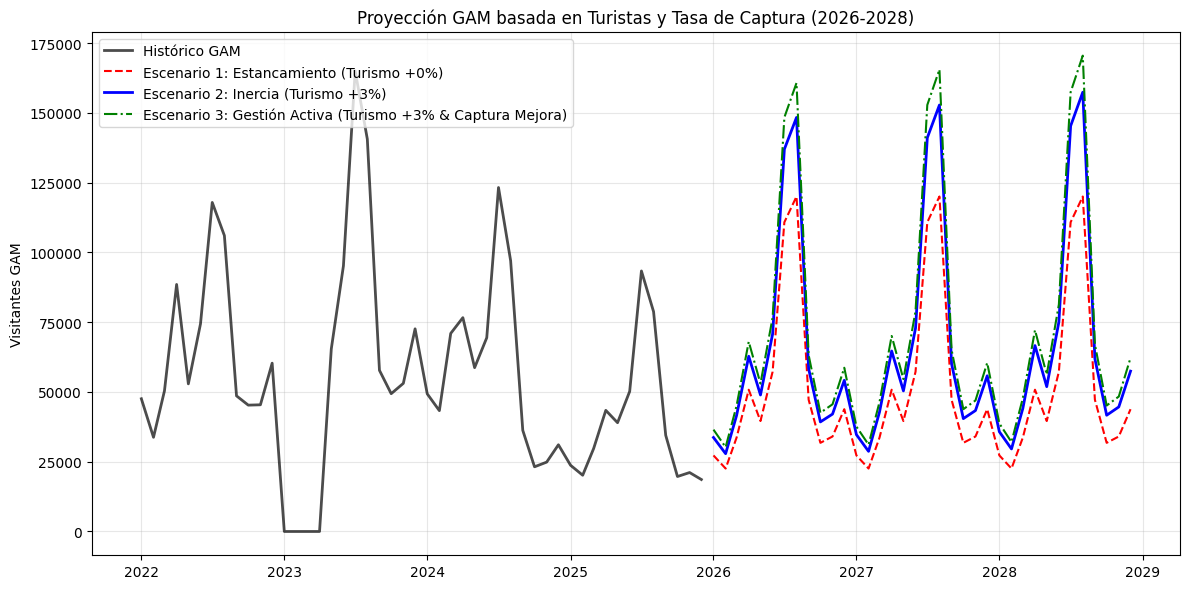

--- PROYECCIÓN TOTAL VISITANTES 2026 ---
Escenario 1 (Conservador): 618,756
Escenario 2 (Moderado):    764,783
Escenario 3 (Optimista):   828,515


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# 1. CARGA DE DATOS (Mismo set de datos anterior)
# ---------------------------------------------------------
data = {
    'Fecha': pd.to_datetime([
        '2022-01-01', '2022-02-01', '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01',
        '2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01', '2022-11-01', '2022-12-01',
        '2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01',
        '2023-07-01', '2023-08-01', '2023-09-01', '2023-10-01', '2023-11-01', '2023-12-01',
        '2024-01-01', '2024-02-01', '2024-03-01', '2024-04-01', '2024-05-01', '2024-06-01',
        '2024-07-01', '2024-08-01', '2024-09-01', '2024-10-01', '2024-11-01', '2024-12-01',
        '2025-01-01', '2025-02-01', '2025-03-01', '2025-04-01', '2025-05-01', '2025-06-01',
        '2025-07-01', '2025-08-01', '2025-09-01', '2025-10-01', '2025-11-01', '2025-12-01'
    ]),
    'GAM': [
        47555, 33752, 50401, 88518, 52899, 74406, 117898, 106035, 48593, 45272, 45395, 60313,
        0, 0, 0, 0, 65396, 95181, 165041, 140610, 57745, 49379, 53081, 72613,
        49328, 43293, 70971, 76619, 58704, 69427, 123249, 97003, 36239, 23176, 24855, 31070,
        23727, 20156, 29739, 43406, 38977, 50204, 93354, 78757, 34471, 19695, 21122, 18624
    ],
    'Turistas': [
        187397, 195151 ,259592 ,286375 ,269962 ,278759 ,280636 ,278508 ,203882 ,216805 ,215150 ,199069, 
        205542, 224725, 205546, 259069, 238674, 215920, 203918, 220828, 182708, 194643, 207397, 203761,
        186327, 191706, 240656, 232581, 233522, 245496, 277021, 254396, 169104, 151484, 160698, 159184,
        111926, 119146, 145608, 170683, 165415, 180548, 208976, 286940, 200755, 174446, 185057, 183313
    ]
}


df = pd.DataFrame(data)
# Filtramos solo donde tenemos datos de ambos para calcular la tasa de captura histórica
df_valid = df[(df['GAM'] > 0) & (df['Turistas'] > 0)].copy()

# ---------------------------------------------------------
# 2. CÁLCULO DE LA TASA DE CAPTURA (CORRELACIÓN PRÁCTICA)
# ---------------------------------------------------------
# Capture Rate = Qué % de los turistas van al GAM cada mes
df_valid['Capture_Rate'] = df_valid['GAM'] / df_valid['Turistas']

# Calculamos un perfil estacional de la tasa de captura
# (Ej: Quizás en Julio el GAM captura el 40%, pero en Octubre solo el 15%)
df_valid['Mes'] = df_valid['Fecha'].dt.month
seasonal_capture_profile = df_valid.groupby('Mes')['Capture_Rate'].mean()

print("--- TASA DE CAPTURA PROMEDIO POR MES (HISTÓRICO) ---")
print(seasonal_capture_profile)

# ---------------------------------------------------------
# 3. FUNCIÓN DE PROYECCIÓN CAUSAL
# ---------------------------------------------------------
def project_causal(years=3, tourist_growth_annual=0.0, gam_efficiency_boost=1.0):
    
    # 1. Base: Tomamos los turistas del último año completo (2025) como base estacional
    last_year_tourists = df[df['Fecha'].dt.year == 2025].set_index(df[df['Fecha'].dt.year == 2025]['Fecha'].dt.month)['Turistas']
    
    future_dates = []
    future_gam = []
    future_tourists = []
    
    start_date = df['Fecha'].max() + pd.DateOffset(months=1) # Enero 2026
    
    for i in range(12 * years):
        current_date = start_date + pd.DateOffset(months=i)
        month_idx = current_date.month
        
        # A. Proyectar Turistas (Variable Independiente)
        year_offset = (i // 12) + 1
        # Aplicamos crecimiento compuesto a los turistas
        monthly_tourist_base = last_year_tourists[month_idx]
        projected_tourist = monthly_tourist_base * ((1 + tourist_growth_annual) ** year_offset)
        
        # B. Proyectar GAM (Variable Dependiente)
        # GAM = Turistas * Tasa_Captura_Histórica * Mejora_Eficiencia
        base_capture = seasonal_capture_profile[month_idx]
        projected_gam_visit = projected_tourist * base_capture * gam_efficiency_boost
        
        future_dates.append(current_date)
        future_gam.append(projected_gam_visit)
        future_tourists.append(projected_tourist)
        
    return pd.DataFrame({'Fecha': future_dates, 'Pred_GAM': future_gam, 'Pred_Turistas': future_tourists})

# ---------------------------------------------------------
# 4. CREACIÓN DE ESCENARIOS
# ---------------------------------------------------------

# Escenario 1: Conservador
# Turistas 0% crecimiento, GAM eficiencia normal (x1.0)
esc_cons = project_causal(tourist_growth_annual=0.0, gam_efficiency_boost=1.0)

# Escenario 2: Moderado (Mercado crece)
# Turistas +3% crecimiento, GAM eficiencia normal (x1.0)
esc_mod = project_causal(tourist_growth_annual=0.03, gam_efficiency_boost=1.2)

# Escenario 3: Optimista (Mercado crece + GAM mejora marketing)
# Turistas +3% crecimiento, GAM mejora su captura un 10% (x1.10)
# (Ej: si capturaba 20%, ahora captura 22%)
esc_opt = project_causal(tourist_growth_annual=0.03, gam_efficiency_boost=1.3)

# ---------------------------------------------------------
# 5. GRÁFICOS
# ---------------------------------------------------------
plt.figure(figsize=(12, 6))

# Datos Históricos
plt.plot(df['Fecha'], df['GAM'], label='Histórico GAM', color='black', linewidth=2, alpha=0.7)

# Proyecciones
plt.plot(esc_cons['Fecha'], esc_cons['Pred_GAM'], '--', label='Escenario 1: Estancamiento (Turismo +0%)', color='red')
plt.plot(esc_mod['Fecha'], esc_mod['Pred_GAM'], '-', label='Escenario 2: Inercia (Turismo +3%)', color='blue', linewidth=2)
plt.plot(esc_opt['Fecha'], esc_opt['Pred_GAM'], '-.', label='Escenario 3: Gestión Activa (Turismo +3% & Captura Mejora)', color='green')

plt.title('Proyección GAM basada en Turistas y Tasa de Captura (2026-2028)')
plt.ylabel('Visitantes GAM')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Mostrar comparativa del total anual para el primer año proyectado
total_2026_cons = esc_cons[esc_cons['Fecha'].dt.year == 2026]['Pred_GAM'].sum()
total_2026_mod = esc_mod[esc_mod['Fecha'].dt.year == 2026]['Pred_GAM'].sum()
total_2026_opt = esc_opt[esc_opt['Fecha'].dt.year == 2026]['Pred_GAM'].sum()

print(f"--- PROYECCIÓN TOTAL VISITANTES 2026 ---")
print(f"Escenario 1 (Conservador): {total_2026_cons:,.0f}")
print(f"Escenario 2 (Moderado):    {total_2026_mod:,.0f}")
print(f"Escenario 3 (Optimista):   {total_2026_opt:,.0f}")

In [ ]:
# # Escenario 1: Conservador
# # Turistas 0% crecimiento, GAM eficiencia normal (x1.0)
# esc_cons 

# Escenario 2: Moderado (Mercado crece)
# Turistas +3% crecimiento, GAM mejora su captura un 20%  (x1.2)
esc_mod
# Escenario 3: Optimista (Mercado crece + GAM mejora marketing)
# Turistas +3% crecimiento, GAM mejora su captura un 30% (x1.30)
# esc_opt

Fecha       Pred_GAM  Pred_Turistas
0  2026-01-01   33685.607860  115283.780000
1  2026-02-01   27879.813580  122720.380000
2  2026-03-01   41591.485719  149976.240000
3  2026-04-01   62785.419117  175803.490000
4  2026-05-01   48913.519161  170377.450000
5  2026-06-01   70774.475823  185964.440000
6  2026-07-01  136966.353311  215245.280000
7  2026-08-01  148357.290513  295548.200000
8  2026-09-01   58335.891839  206777.650000
9  2026-10-01   39263.418661  179679.380000
10 2026-11-01   42071.434832  190608.710000
11 2026-12-01   54158.110750  188812.390000
12 2027-01-01   34696.176095  118742.293400
13 2027-02-01   28716.207987  126401.991400
14 2027-03-01   42839.230291  154475.527200
15 2027-04-01   64668.981691  181077.594700
16 2027-05-01   50380.924736  175488.773500
17 2027-06-01   72897.710097  191543.373200
18 2027-07-01  141075.343911  221702.638400
19 2027-08-01  152808.009229  304414.646000
20 2027-09-01   60085.968594  212980.979500
21 2027-10-01   40441.321221  185069.761400
22 2027-11-01   43333.577877  196326.971300
23 2027-12-01   55782.854073  194476.761700
24 2028-01-01   35737.061378  122304.562202
25 2028-02-01   29577.694227  130194.051142
26 2028-03-01   44124.407200  159109.793016
27 2028-04-01   66609.051142  186509.922541
28 2028-05-01   51892.352478  180753.436705
29 2028-06-01   75084.641400  197289.674396
30 2028-07-01  145307.604228  228353.717552
31 2028-08-01  157392.249505  313547.085380
32 2028-09-01   61888.547652  219370.408885
33 2028-10-01   41654.560858  190621.854242
34 2028-11-01   44633.585213  202216.780439
35 2028-12-01   57456.339695  200311.064551